In [ ]:
# %pip install numpy matplotlib oasis-deconv

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from oasis.functions import deconvolve

c:\Users\sange\anaconda3\envs\s2p\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [11]:
traces = np.load("data/F.npy")
cal_traces = []
dtraces = []

for i, trace in enumerate(traces):
    F = trace.copy()
    F0 = np.median(F)
    cal_trace = (F - F0) / abs(F0)
    try:
        _, dt, _, _, _ = deconvolve(cal_trace)
        cal_traces.append(cal_trace)
        dtraces.append(dt)
    except:
        continue

C:\Users\sange\AppData\Local\Temp\ipykernel_18424\3552383840.py:8: RuntimeWarning: invalid value encountered in divide
  cal_trace = (F - F0) / abs(F0)


In [37]:
ind = 11
trace = cal_traces[ind].copy()
dtrace = dtraces[ind].copy()

In [72]:
trace1 = cal_traces[25].copy()
dtrace1 = dtraces[25].copy()

trace2 = cal_traces[5].copy()
dtrace2 = dtraces[5].copy()

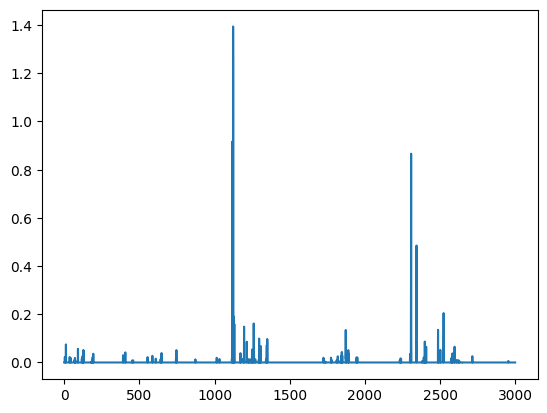

In [75]:
plt.plot(dtrace2)

# Thresholding and Events: Converting Continuous Calcium Traces into Discrete Event Times

In this module, we will analyze the deconvolved output of calcium imaging data to extract discrete neural events. The deconvolved signal, inferred using the OASIS algorithm, provides a continuous estimate of spiking activity over time. However, this signal includes small amplitude fluctuations that may not reflect actual spikes. To interpret this signal meaningfully, we must detect and extract the time points at which neurons were most likely active. This notebook guides you through this process, starting with thresholding the deconvolved signal, identifying event onsets, and ending with the computation of firing rate traces.


## Understanding and Thresholding the Deconvolved Signal

The deconvolved signal returned by OASIS is sparse but continuous. While many values are close to zero, not all non-zero points correspond to real spike events. In this section, we will inspect the deconvolved traces from selected neurons and apply amplitude thresholding to isolate frames with significant spiking activity. This step filters out low-amplitude noise and prepares the signal for event detection.

When thresholding the deconvolved signal, your goal is to keep sharp, isolated peaks while ignoring small background fluctuations. 

To begin, we try a simple manual threshold. This helps us visually check which parts of the deconvolved trace are above a chosen cutoff. We are not detecting events yet. We are just seeing where the signal exceeds a fixed value.

**Example** Plot the deconvolved trace. Add a line at 0.15.

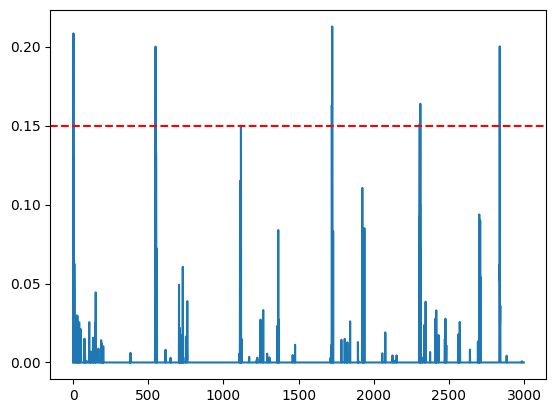

In [41]:
plt.plot(dtrace)
plt.axhline(0.15, color='r', linestyle='--');

Plot the deconvolved trace. Add a line at 0.0001.

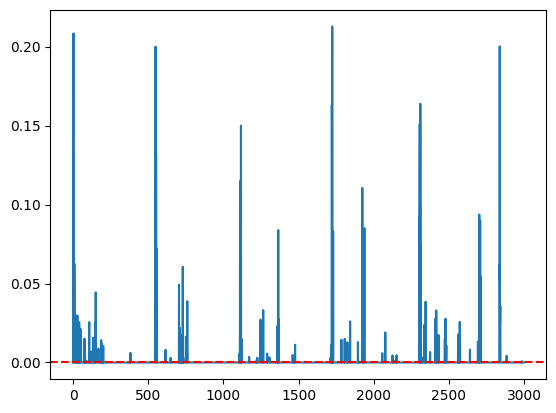

In [42]:
plt.plot(dtrace)
plt.axhline(0.0001, color='r', linestyle='--');

Plot the deconvolved trace. Set y-axis to (0, 0.01). Add a line at 0.00001.

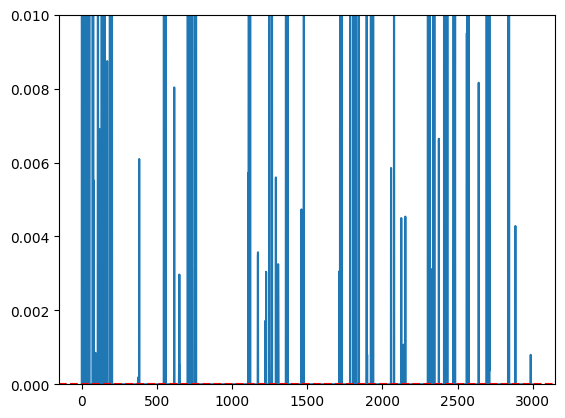

In [47]:
plt.plot(dtrace)
plt.ylim(0.00, 0.01)
plt.axhline(0.00001, color='r', linestyle='--');

Plot the deconvolved trace. Add a line at 0.002.

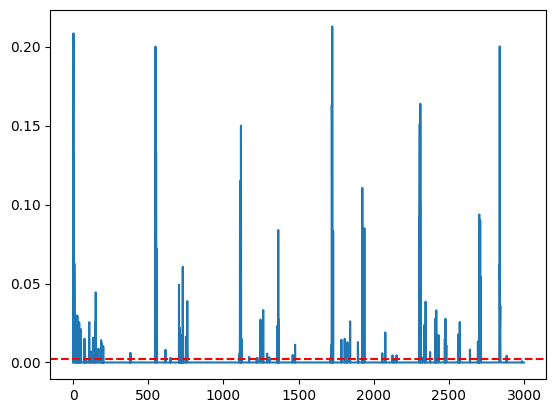

In [49]:
plt.plot(dtrace)
plt.axhline(0.002, color='r', linestyle='--');

Now we apply the threshold to the deconvolved signal and count how many frames are above it. This gives us a rough idea of how active the neuron appears, based on the chosen threshold.

**Example** Set threshold to 0.15. Count how many values in the deconvolved trace are above this threshold.

In [50]:
np.sum(dtrace > 0.15)

np.int64(7)

Set threshold to 0.002. Count how many values are above this threshold.

In [51]:
np.sum(dtrace > 0.002)

np.int64(137)

Set threshold to 0.00001. Count how many values are above this threshold.

In [52]:
np.sum(dtrace > 0.00001)

np.int64(160)

Instead of choosing a threshold manually, we can use a data-driven rule: mean + 2 × standard deviation. This sets the threshold relative to the baseline and variability in the signal. We then count how many frames exceed this automatic threshold.

Automatic thresholds depend on both the baseline (mean or median) and the spread (standard deviation) of the deconvolved signal. By trying different combinations, we can begin to choose thresholds that are sensitive to strong activity, while ignoring low-level noise.

**Example** Set threshold to mean + 10 × std. Count how many values are above this threshold.

In [53]:
mu = np.mean(dtrace)
sigma = np.std(dtrace)
auto_thresh = mu + 10 * sigma
np.sum(dtrace > auto_thresh)

np.int64(9)

Set threshold to mean + 5 × std. Count how many values are above this threshold.

In [59]:
mu = np.mean(dtrace)
sigma = np.std(dtrace)
auto_thresh = mu + 5 * sigma
np.sum(dtrace > auto_thresh)

np.int64(31)

Set threshold to median + 2 × std. Count how many values are above this threshold.

In [58]:
mu = np.median(dtrace)
sigma = np.std(dtrace)
auto_thresh = mu + 2.0 * sigma
np.sum(dtrace > auto_thresh)

np.int64(57)


## Identifying Spike Times from Thresholded Signal

After applying a threshold to the deconvolved signal, we are left with a list of frames where the signal is high. However, these high values often span several consecutive frames for a single spike event. Instead of treating every suprathreshold frame as a separate spike, we want to detect only the onset of each event — the frame where the activity first crosses the threshold. This gives us a cleaner, more biologically meaningful list of spike times. To do this, we will follow three steps:

- Convert the thresholded signal into a binary (0 or 1) vector
- `Use np.diff()` to detect where the signal changes from 0 to 1
- Convert those indices to timestamps using the frame rate

We start by converting the deconvolved trace into a binary vector using a threshold. This shows us where spikes might be present (1) and where there is no activity (0). We plot both the original deconvolved signal and the binary spike vector together.

**Example** Threshold the deconvolved trace at 0.02 plot both the trace and the binary vector.

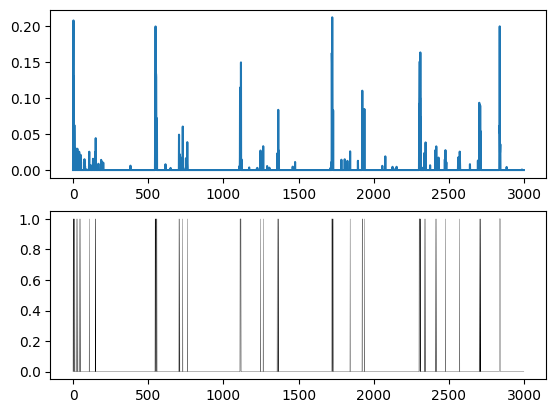

In [210]:
binary = dtrace > 0.02

plt.subplot(211)
plt.plot(dtrace)

plt.subplot(212)
plt.plot(binary, color='black', linewidth=0.2)

Threshold the deconvolved trace1 at 0.2 plot both the trace and the binary vector.

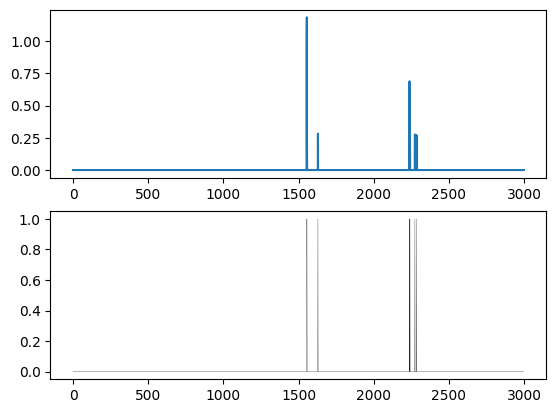

In [211]:
binary1 = dtrace1 > 0.2

plt.subplot(211)
plt.plot(dtrace1)

plt.subplot(212)
plt.plot(binary1, color='black', linewidth=0.2)

Threshold the deconvolved trace2 at 0.002 and plot both the trace and the binary vector.

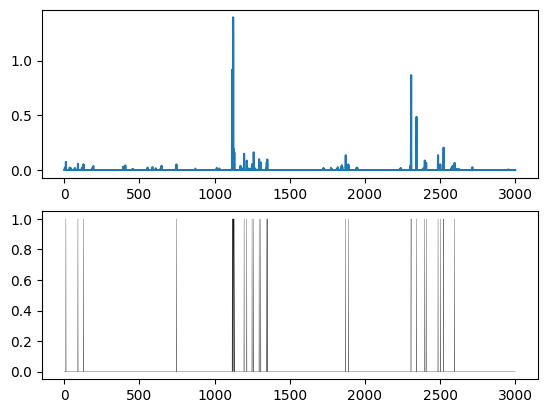

In [ ]:
binary2 = dtrace2 > 0.05

plt.subplot(211)
plt.plot(dtrace2)

plt.subplot(212)
plt.plot(binary2, color='black', linewidth=0.2)

To find the start of each spike event, we look for where the binary vector changes from 0 to 1. These transitions mark the onset of activity. We use `np.diff()` to compute the difference between consecutive frames and then look for values equal to 1.

**Example** How many spike onsets in trace?

In [213]:
diff = np.diff(binary.astype(int))
onsets = np.where(diff == 1)[0] + 1
np.sum(binary), len(onsets)

(np.int64(72), 46)

How many spike onsets in trace1?

In [214]:
diff = np.diff(binary1.astype(int))
onsets1 = np.where(diff == 1)[0] + 1
np.sum(binary1), len(onsets1)

(np.int64(9), 6)

How many spike onsets in trace2?

In [215]:
diff = np.diff(binary2.astype(int))
onsets2 = np.where(diff == 1)[0] + 1
np.sum(binary2), len(onsets2)

(np.int64(36), 26)

The spike onset indices give us the frame number of each event. To convert these to spike times in seconds, we multiply the indices by the frame interval `dt`. If the frame rate is 30 Hz, then `dt = 1 / 30`.

**Example** Convert the onset indices (trace) to spike times (Frame Rate = 30 Hz).


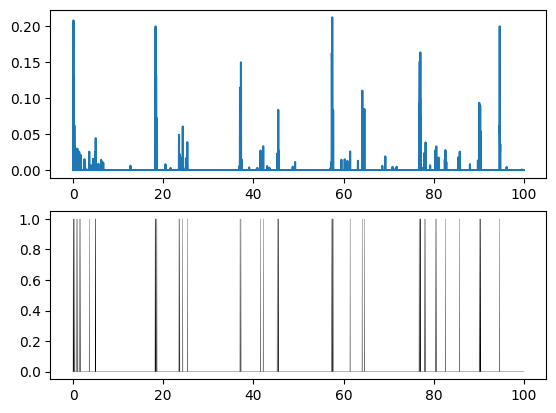

In [219]:
dt = 1 / 30
t = np.arange(len(dtrace)) * dt
spike_times = np.zeros_like(t)
spike_times[onsets] = 1

plt.subplot(211)
plt.plot(t, dtrace)

plt.subplot(212)
plt.plot(t, spike_times, color='black', linewidth=0.2)

Convert the onset indices (trace1) to spike times

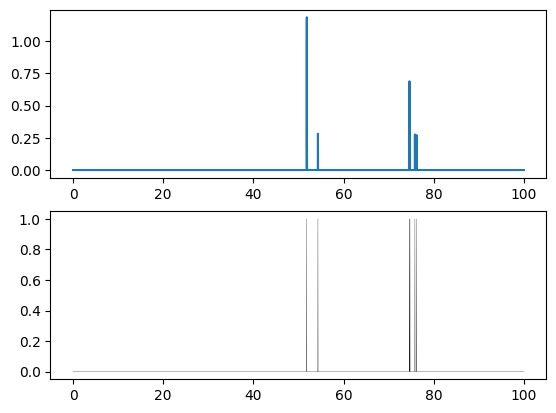

In [220]:
dt = 1 / 30
t = np.arange(len(dtrace)) * dt
spike_times1 = np.zeros_like(t)
spike_times1[onsets1] = 1

plt.subplot(211)
plt.plot(t, dtrace1)

plt.subplot(212)
plt.plot(t, spike_times1, color='black', linewidth=0.2)


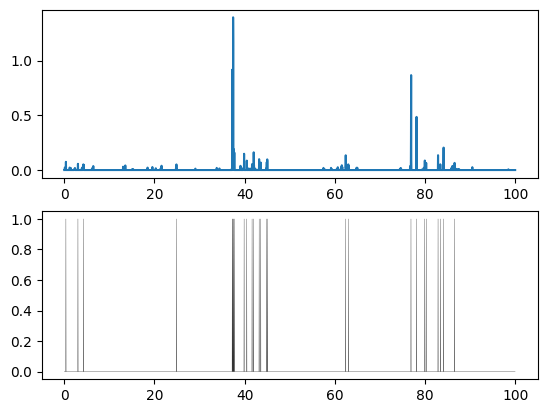

In [221]:
dt = 1 / 30

t = np.arange(len(dtrace)) * dt
spike_times2 = np.zeros_like(t)
spike_times2[onsets2] = 1

plt.subplot(211)
plt.plot(t, dtrace2)

plt.subplot(212)
plt.plot(t, spike_times2, color='black', linewidth=0.2)

## Visualizing Spike Events on Top of the Deconvolved Trace

Once spike times have been extracted, we will overlay them on the original deconvolved signal. This visualization step helps verify whether the detected events align well with peaks in the trace and provides a chance to visually inspect the effects of the thresholding process. It also allows for a qualitative assessment of signal quality across neurons.

**Extract spike trains**

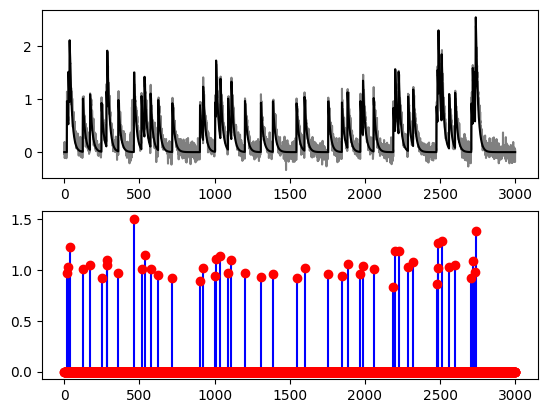

In [161]:
denoised_signal, spike_train, _, _, _ = deconvolve(fluorescence_trace_1)

plt.subplot(211)
plt.plot(fluorescence_trace_1, color='gray')
plt.plot(denoised_signal, color='k')

plt.subplot(212)
plt.stem(range(len(spike_train)), spike_train, basefmt=" ", linefmt='b-', markerfmt='ro');

**Extract spike indices and amplitudes**

Find all time points where the inferred spike amplitude is greater than zero.

c:\Users\sangeetha\miniforge3\envs\calim\Lib\site-packages\oasis\functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],


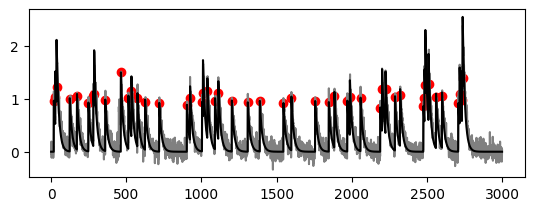

In [176]:
denoised_signal, spike_train, _, _, _ = deconvolve(fluorescence_trace_1)

spike_indices = np.where(np.round(spike_train) > 0)[0]
spike_amplitudes = spike_train[spike_indices]

plt.subplot(211)
plt.plot(fluorescence_trace_1, color='gray')
plt.plot(denoised_signal, color='k')
plt.scatter(np.arange(len(spike_train))[spike_indices], spike_train[spike_indices], color='r')

## Estimating Firing Rate from Extracted Spike Times

The final step in this analysis is to convert spike times into a time-resolved firing rate. By binning the spike events into equally spaced time intervals and normalizing by bin width, we can compute the firing rate of each neuron across the recording. This representation is essential for many forms of downstream analysis, including population coding, condition comparisons, and temporal alignment with behavior.